In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tokenization
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from keras.utils import to_categorical
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
!pip install tokenization

# Load dataset

In [ ]:
# Path to the dataset directory
dataset_path = '/content/drive/MyDrive/Document Classificaion/archive (3)/bbc'

# Initialize an empty list to store data
data = []

# Loop through each category folder
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        # Loop through each file in the category folder
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)

            # Check if the file is a TXT file
            if file_name.endswith('.txt'):
                # Read the content of the TXT file
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:  # Add errors='ignore' to handle encoding errors
                    content = file.read()

                    # Append the data to the list
                    data.append({'Document': content, 'Class': category})

# Convert the list to a DataFrame
df = pd.DataFrame(data, columns=['Document', 'Class'])


### Create Csv file

In [ ]:
# Save the DataFrame to a CSV file
csv_file_path = '/content/drive/MyDrive/Document Classificaion/dataset.csv'
df.to_csv(csv_file_path, index=False)


In [ ]:
# Load the dataset
df = pd.read_csv(r'/content/drive/MyDrive/Document Classificaion/dataset.csv')
df.head()

,Document,Class
0,Hewitt decries 'career sexism'\n\nPlans to ext...,politics
1,Labour plans maternity pay rise\n\nMaternity p...,politics
2,Watchdog probes e-mail deletions\n\nThe inform...,politics
3,Labour chooses Manchester\n\nThe Labour Party ...,politics
4,Crucial decision on super-casinos\n\nA decisio...,politics


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Document').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Getting the number of rows and columns
num_rows, num_columns = df.shape

# Printing the number of rows and columns
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 2225
Number of columns: 2


In [ ]:
df.isna().sum()

Document    0
Class       0
dtype: int64

In [ ]:
classesList = df['Class'].unique()
classesList

array(['politics', 'sport', 'tech', 'entertainment', 'business'],
      dtype=object)

In [ ]:
df['Class'].value_counts()

Class
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

## Visualization

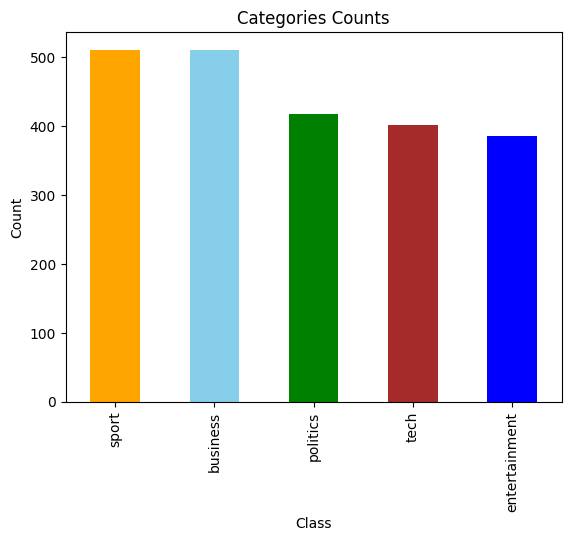

In [ ]:
email_type_counts = df['Class'].value_counts()

# Plotting the bar plot with two different colors
colors = ['orange', 'skyblue','green','brown','blue']  # Define the colors you want to use

# Create the plot
ax = email_type_counts.plot(kind='bar', color=colors)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Categories Counts')

# Display the plot
plt.show()

##Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()

df['Class'] = lbl.fit_transform(df['Class'])

## Text Preprocessing

In [ ]:
import re
# Preprocess the text
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Document'] = df['Document'].apply(preprocess_text)

In [ ]:
df.head()

,Document,Class
0,hewitt decries career sexism plans to extend p...,2
1,labour plans maternity pay rise maternity pay ...,2
2,watchdog probes email deletions the informatio...,2
3,labour chooses manchester the labour party wil...,2
4,crucial decision on supercasinos a decision on...,2


### wordcloud of available stopwords

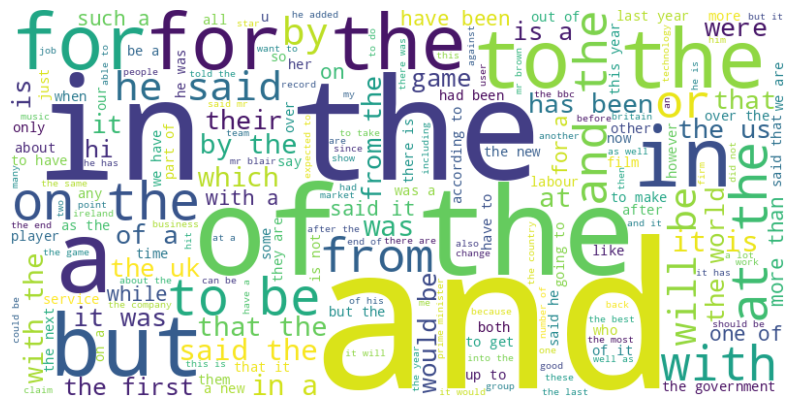

In [ ]:
from wordcloud import WordCloud

#combine all rows into a single string
all_mails=" ".join(df['Document'])

#create a wordcloud object
word_cloud = WordCloud(stopwords="english",width=800,height=400,background_color='white').generate(all_mails)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

### wordcloude of unique words

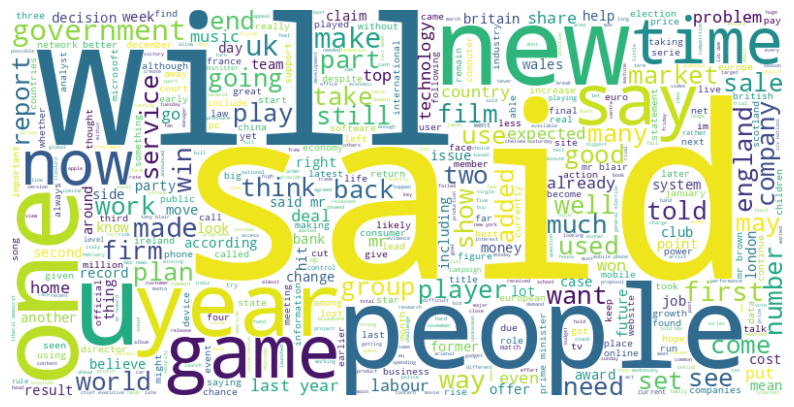

In [ ]:
#combine all rows into a single string
all_mails = " ".join(df['Document'])

#create a wordcloud object
word_cloud = WordCloud(width=800,height=400,background_color='white',max_words=10000).generate(all_mails)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Document'], df['Class'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Encode the labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.fit_transform(y_test)

# Convert labels to categorical
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

In [ ]:
joblib.dump(vectorizer, '/content/drive/MyDrive/Document Classificaion/models/tfidf_vectorizer.pkl')

['/content/drive/MyDrive/Document Classificaion/models/tfidf_vectorizer.pkl']

#Build and Train models

###CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
# Define the model
model = Sequential()
model.add(Dense(512, input_shape=(5000,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_vec, y_train_cat, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/20
45/45 - 4s - loss: 1.2061 - accuracy: 0.6489 - val_loss: 0.3262 - val_accuracy: 0.9691 - 4s/epoch - 89ms/step
Epoch 2/20
45/45 - 2s - loss: 0.1329 - accuracy: 0.9747 - val_loss: 0.0771 - val_accuracy: 0.9719 - 2s/epoch - 40ms/step
Epoch 3/20
45/45 - 1s - loss: 0.0303 - accuracy: 0.9937 - val_loss: 0.0712 - val_accuracy: 0.9747 - 1s/epoch - 32ms/step
Epoch 4/20
45/45 - 2s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0614 - val_accuracy: 0.9747 - 2s/epoch - 37ms/step
Epoch 5/20
45/45 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0621 - val_accuracy: 0.9747 - 1s/epoch - 33ms/step
Epoch 6/20
45/45 - 2s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0649 - val_accuracy: 0.9691 - 2s/epoch - 34ms/step
Epoch 7/20
45/45 - 2s - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0605 - val_accuracy: 0.9719 - 2s/epoch - 34ms/step
Epoch 8/20
45/45 - 2s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0633 - val_accuracy: 0.9691 - 2s/epoch - 34ms/step
Epoch 9/20
45/45 - 3s - loss: 0.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the classes
y_pred_cat = model.predict(X_test_vec)
y_pred = np.argmax(y_pred_cat, axis=1)

# Ensure the target names are strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Print the classification report
print(classification_report(y_test_enc, y_pred, target_names=target_names))

# Print the accuracy
accuracy = np.mean(y_test_enc == y_pred)
print(f'Accuracy: {accuracy:.2f}')


14/14 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       102
           1       0.99      1.00      0.99        76
           2       0.96      0.97      0.96        92
           3       0.99      1.00      0.99        98
           4       0.96      0.99      0.97        77

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445

Accuracy: 0.98


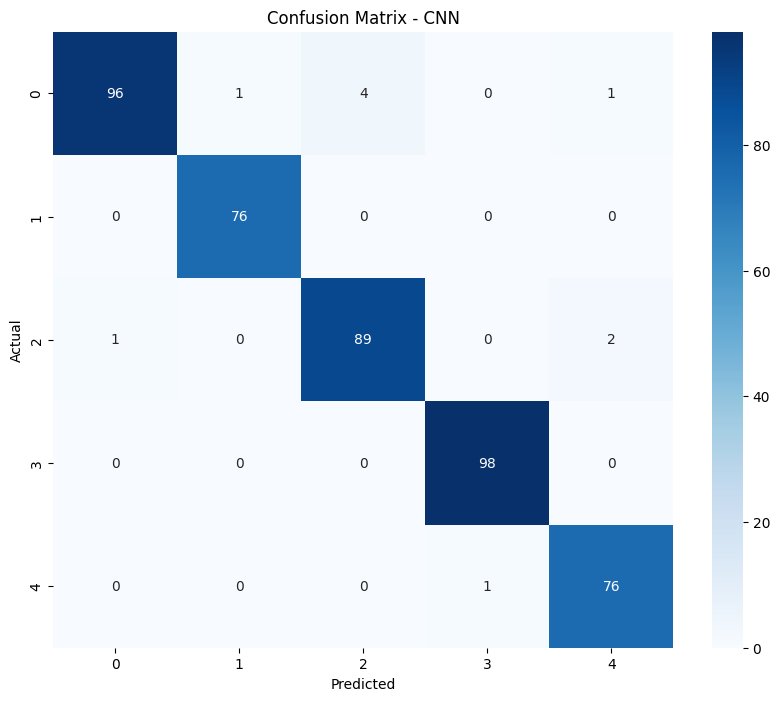

In [ ]:
## Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm_cnn = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Save the model in HDF5 format
model.save('/content/drive/MyDrive/Document Classificaion/models/cnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Prediction

In [ ]:
def predict_class(document, tfidf_vectorizer, model, label_encoder):
    # Preprocess the text
    preprocessed_text = preprocess_text(document)

    # Vectorize the new text using the provided TF-IDF vectorizer
    new_text_feature = tfidf_vectorizer.transform([preprocessed_text]).toarray()

    # Make prediction
    prediction = model.predict(new_text_feature)

    # Get the index of the class with the highest probability
    max_prob_index = prediction.argmax()

    # Retrieve the class name associated with the highest probability
    class_name = label_encoder.classes_[max_prob_index]

    return class_name

In [ ]:

# Define label encoder classes
label_encoder_classes = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Create a dictionary mapping class indices to class names
class_index_to_name = {index: name for index, name in enumerate(label_encoder_classes)}

# Example new text
new_text = """The film industry is buzzing with excitement as the highly anticipated blockbuster hits theaters worldwide. With a star-studded cast and groundbreaking special effects, this movie promises to be a thrilling ride from start to finish. Fans have been eagerly awaiting its release, and early reviews are overwhelmingly positive. From heart-pounding action sequences to tear-jerking emotional moments, this film has it all. Grab your popcorn and get ready for an unforgettable cinematic experience!
"""

# Use the same TF-IDF vectorizer used for training
predicted_class_index = predict_class(new_text, vectorizer, model, label_encoder)
predicted_class_name = class_index_to_name[predicted_class_index]
print(predicted_class_name)


1/1 [==============================] - 0s 44ms/step
entertainment


In [ ]:

# Define label encoder classes
label_encoder_classes = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Create a dictionary mapping class indices to class names
class_index_to_name = {index: name for index, name in enumerate(label_encoder_classes)}

# Example new text
new_text = """In the upcoming fiscal year, we anticipate robust growth driven by technological advancements and market expansion. Projected global economic growth of 3.5% will provide a favorable backdrop, though regional variations will require targeted strategies. Our industry is set to grow at a CAGR of 4.2%, with digital transformation and sustainability being key drivers. We forecast a 10% increase in revenue, supported by new product launches and market diversification. Enhancing customer retention through personalized engagement and improving operational efficiency via automation will be critical. Despite potential risks from economic fluctuations and cybersecurity threats, our strategic initiatives in cost management and sustainability will position us well for continued success.
"""

# Use the same TF-IDF vectorizer used for training
predicted_class_index = predict_class(new_text, vectorizer, model, label_encoder)
predicted_class_name = class_index_to_name[predicted_class_index]
print(predicted_class_name)


1/1 [==============================] - 0s 43ms/step
business


In [ ]:

# Define label encoder classes
label_encoder_classes = ['business', 'entertainment', 'politics', 'sport', 'tech']

# Create a dictionary mapping class indices to class names
class_index_to_name = {index: name for index, name in enumerate(label_encoder_classes)}

# Example new text
new_text = """In the realm of politics, the upcoming year is poised to witness significant shifts and challenges. Global geopolitics will continue to be shaped by complex dynamics, including ongoing trade disputes, regional conflicts, and diplomatic negotiations. Domestically, political landscapes in many countries are expected to undergo transformations influenced by socio-economic factors and public sentiment. Elections in key regions will be closely watched, with outcomes likely to impact policy directions and international relations. Additionally, issues such as climate change, immigration, and healthcare are expected to feature prominently on political agendas, driving discourse and policy formulation. Amidst these developments, agile leadership and adept diplomacy will be essential in navigating uncertainties and advancing national interests on the global stage.


"""

# Use the same TF-IDF vectorizer used for training
predicted_class_index = predict_class(new_text, vectorizer, model, label_encoder)
predicted_class_name = class_index_to_name[predicted_class_index]
print(predicted_class_name)


1/1 [==============================] - 0s 34ms/step
politics


In [ ]:
import tensorflow as tf
import joblib
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the trained CNN model
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Document Classificaion/models/cnn_model.h5')

# Load the TF-IDF vectorizer
tfidf_vectorizer = joblib.load('/content/drive/MyDrive/Document Classificaion/models/tfidf_vectorizer.pkl')

# Initialize label encoder with predefined classes
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['business', 'entertainment', 'politics', 'sport', 'tech'])

def preprocess_text(document):
    # Remove URLs
    document = re.sub(r'http\S+', '', document)
    # Remove punctuation
    document = re.sub(r'[^\w\s]', '', document)
    # Convert to lowercase
    document = document.lower()
    # Remove extra whitespace
    document = re.sub(r'\s+', ' ', document).strip()
    return document

def predict_class(document, tfidf_vectorizer, model, label_encoder):
    # Preprocess the text
    preprocessed_text = preprocess_text(document)

    # Vectorize the new text using the provided TF-IDF vectorizer
    new_text_feature = tfidf_vectorizer.transform([preprocessed_text])

    # Expand dimensions to fit the CNN input shape
    new_text_feature_expanded = np.expand_dims(new_text_feature.toarray(), axis=-1)

    # Make prediction
    prediction = model.predict(new_text_feature_expanded)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # Retrieve the class name associated with the highest probability
    class_name = label_encoder.inverse_transform([predicted_class_index])[0]

    return class_name

# Example new text
new_text = """The film industry is buzzing with excitement as the highly anticipated blockbuster hits theaters worldwide. With a star-studded cast and groundbreaking special effects, this movie promises to be a thrilling ride from start to finish. Fans have been eagerly awaiting its release, and early reviews are overwhelmingly positive. From heart-pounding action sequences to tear-jerking emotional moments, this film has it all. Grab your popcorn and get ready for an unforgettable cinematic experience!
"""

# Predict the class of the new text
predicted_class_name = predict_class(new_text, tfidf_vectorizer, cnn_model, label_encoder)
print(predicted_class_name)


1/1 [==============================] - 0s 308ms/step
entertainment


##function to train and evaluate models

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

def train_evaluate_model(model, param_grid, model_name):
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train_vec, y_train_cat)  # Corrected the typo here
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_vec)

    # Print the best parameters and evaluation metrics
    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Accuracy:", accuracy_score(y_test, y_pred))
    print(f"{model_name} F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))

    return best_model, y_pred

### SVM

In [ ]:
# Define your SVM model and parameter grid for multi-class classification
svm = SVC()
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}

# Load or prepare your dataset vectors and target variables
# X_train_vec, X_test_vec, y_train, y_test = ... # Ensure these variables are defined

# Train and evaluate the SVM model
print("\nSupport Vector Machine (SVM) Classifier:")
best_svm, y_pred_svm = train_evaluate_model(svm, param_grid_svm, "SVM")


Support Vector Machine (SVM) Classifier:
Fitting 5 folds for each of 18 candidates, totalling 90 fits
SVM Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
SVM Accuracy: 0.9797752808988764
SVM F1 Score (weighted): 0.979755690002881
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       102
           1       0.95      1.00      0.97        76
           2       0.98      0.98      0.98        92
           3       1.00      1.00      1.00        98
           4       0.97      0.97      0.97        77

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



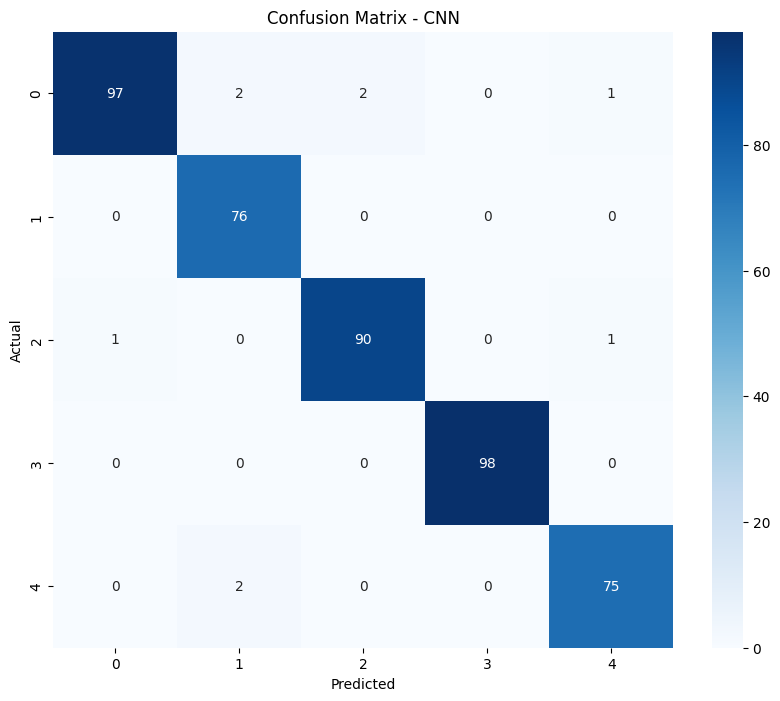

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import joblib
import pickle
joblib.dump(best_svm, '/content/drive/MyDrive/Document Classificaion/models/svm.joblib')
with open('/content/drive/MyDrive/Document Classificaion/models/svm.pkl', 'wb') as f:
    pickle.dump(best_svm, f)

In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re

# Load the trained SVM model
svm_model = joblib.load('/content/drive/MyDrive/Document Classificaion/models/svm.joblib')

# Load the TF-IDF vectorizer
tfidf_vectorizer = joblib.load('/content/drive/MyDrive/Document Classificaion/models/tfidf_vectorizer.pkl')

# Initialize label encoder with predefined classes
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['business', 'entertainment', 'politics', 'sport', 'tech'])

def preprocess_text(document):
    # Remove URLs
    document = re.sub(r'http\S+', '', document)
    # Remove punctuation
    document = re.sub(r'[^\w\s]', '', document)
    # Convert to lowercase
    document = document.lower()
    # Remove extra whitespace
    document = re.sub(r'\s+', ' ', document).strip()
    return document

def predict_class(document, tfidf_vectorizer, model, label_encoder):
    # Preprocess the text
    preprocessed_text = preprocess_text(document)

    # Vectorize the new text using the provided TF-IDF vectorizer
    new_text_feature = tfidf_vectorizer.transform([preprocessed_text])

    # Convert the sparse matrix to a dense array
    new_text_feature_dense = new_text_feature.toarray()

    # Make prediction
    prediction = model.predict(new_text_feature_dense)

    # Get the index of the class with the highest probability
    predicted_class_index = prediction[0]

    # Retrieve the class name associated with the highest probability
    class_name = label_encoder.inverse_transform([predicted_class_index])[0]

    return class_name

# Example new text
new_text = """The film industry is buzzing with excitement as the highly anticipated blockbuster hits theaters worldwide. With a star-studded cast and groundbreaking special effects, this movie promises to be a thrilling ride from start to finish. Fans have been eagerly awaiting its release, and early reviews are overwhelmingly positive. From heart-pounding action sequences to tear-jerking emotional moments, this film has it all. Grab your popcorn and get ready for an unforgettable cinematic experience!
"""

# Predict the class of the new text
predicted_class_name = predict_class(new_text, tfidf_vectorizer, svm_model, label_encoder)
print(predicted_class_name)


entertainment


###Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
print("\nNaive Bayes Classifier:")
naive_bayes = MultinomialNB()
param_grid_naive_bayes = {'alpha': [0.1, 0.5, 1.0]}
best_naive_bayes, y_pred_naive_bayes = train_evaluate_model(naive_bayes, param_grid_naive_bayes, "Naive Bayes")


Naive Bayes Classifier:
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Naive Bayes Best Parameters: {'alpha': 0.1}
Naive Bayes Accuracy: 0.9752808988764045
Naive Bayes F1 Score (weighted): 0.9752036312545203
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       102
           1       0.99      1.00      0.99        76
           2       0.95      0.98      0.96        92
           3       0.99      1.00      0.99        98
           4       0.97      0.96      0.97        77

    accuracy                           0.98       445
   macro avg       0.98      0.98      0.98       445
weighted avg       0.98      0.98      0.98       445



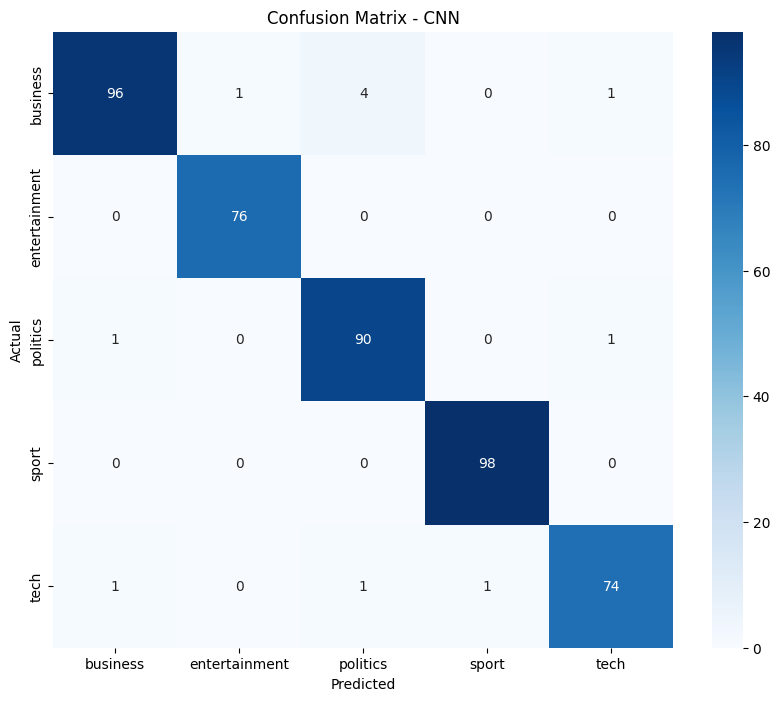

In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_naive_bayes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import joblib
import pickle
joblib.dump(best_naive_bayes, '/content/drive/MyDrive/Document Classificaion/models/naive_bayes.joblib')
with open('/content/drive/MyDrive/Document Classificaion/models/naive_bayes.pkl', 'wb') as f:
    pickle.dump(best_naive_bayes, f)

###Decision Tree

In [ ]:
print("\nDecision Tree Classifier:")
dec_tree = DecisionTreeClassifier()
param_grid_dec_tree = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 10, 20]}
best_dec_tree, y_pred_dec_tree = train_evaluate_model(dec_tree, param_grid_dec_tree, "Decision Tree")


Decision Tree Classifier:
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Decision Tree Best Parameters: {'max_depth': 20, 'min_samples_split': 2}
Decision Tree Accuracy: 0.802247191011236
Decision Tree F1 Score (weighted): 0.8014057762673051
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76       102
           1       0.83      0.72      0.77        76
           2       0.83      0.76      0.80        92
           3       0.80      0.90      0.85        98
           4       0.82      0.84      0.83        77

    accuracy                           0.80       445
   macro avg       0.81      0.80      0.80       445
weighted avg       0.80      0.80      0.80       445



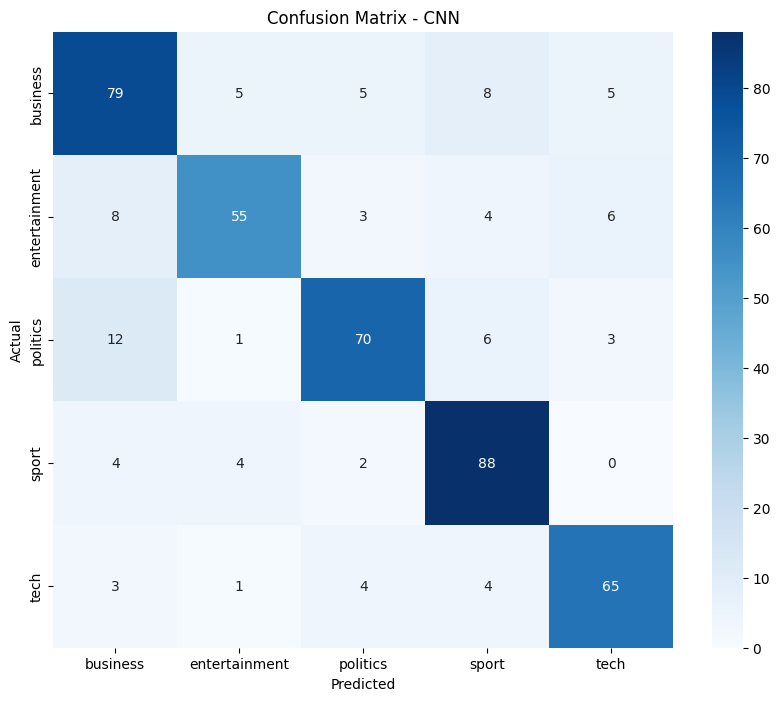

In [ ]:
cm_dt = confusion_matrix(y_test, y_pred_dec_tree)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import joblib
import pickle
joblib.dump(best_dec_tree, '/content/drive/MyDrive/Document Classificaion/models/dec_tree.joblib')
with open('/content/drive/MyDrive/Document Classificaion/models/dec_tree.pkl', 'wb') as f:
    pickle.dump(best_dec_tree, f)

### Random forest

In [ ]:
print("\nRandom Forest Classifier:")
rand_forest = RandomForestClassifier()
param_grid_rand_forest = {'n_estimators': [100, 200, 500], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 10, 20]}
best_rand_forest, y_pred_rand_forest = train_evaluate_model(rand_forest, param_grid_rand_forest, "Random Forest")


Random Forest Classifier:
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Random Forest Best Parameters: {'max_depth': None, 'min_samples_split': 20, 'n_estimators': 500}
Random Forest Accuracy: 0.9730337078651685
Random Forest F1 Score (weighted): 0.9729911046116998
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       102
           1       0.99      0.97      0.98        76
           2       0.97      0.96      0.96        92
           3       0.98      1.00      0.99        98
           4       0.97      0.97      0.97        77

    accuracy                           0.97       445
   macro avg       0.97      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445



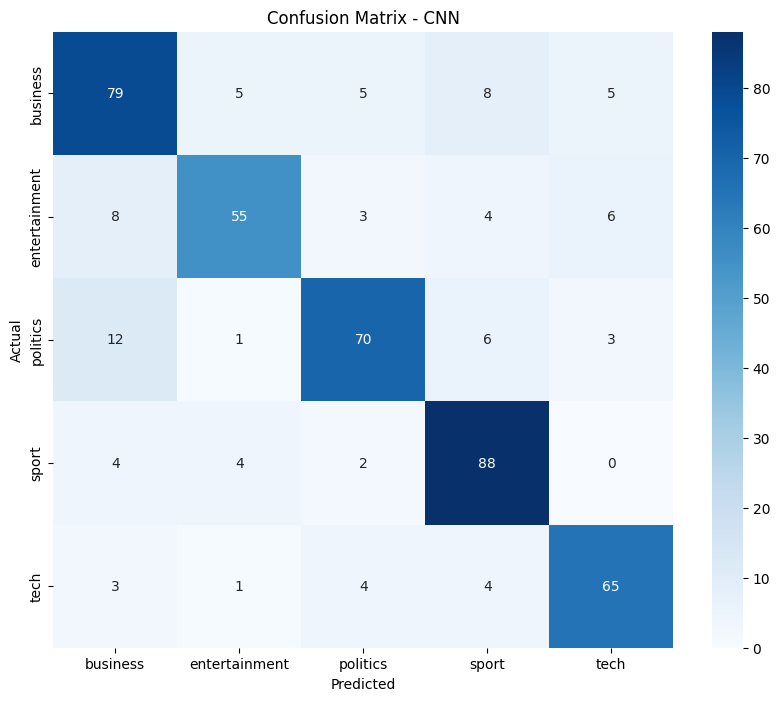

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_dec_tree)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import joblib
import pickle
joblib.dump(best_rand_forest, '/content/drive/MyDrive/Document Classificaion/models/rand_forest.joblib')
with open('/content/drive/MyDrive/Document Classificaion/models/rand_forest.pkl', 'wb') as f:
    pickle.dump(best_rand_forest, f)

# Comparison

<ipython-input-71-d017b1228661>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=[acc * 100 for acc in accuracies], palette='Set2')


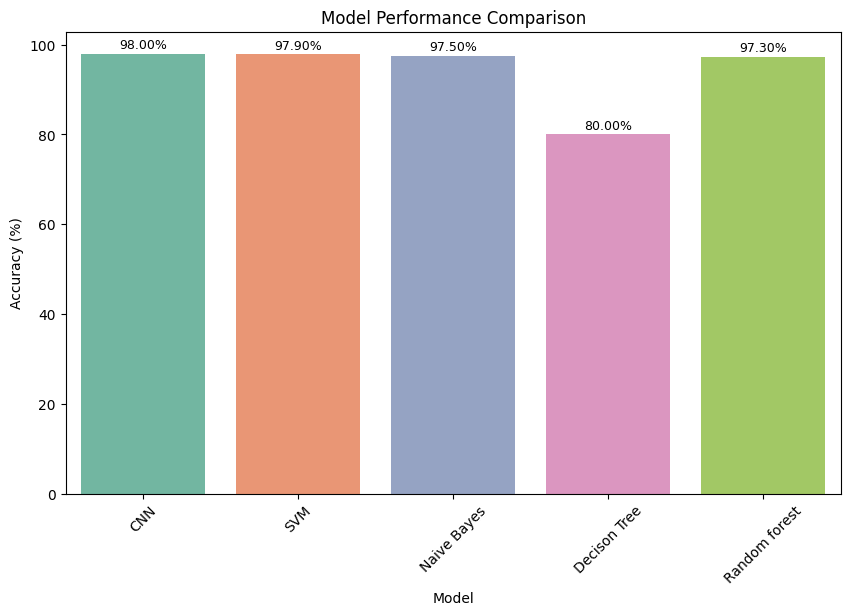

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model names
model_names = ['CNN', 'SVM', 'Naive Bayes', 'Decison Tree', 'Random forest']

# Accuracies obtained from recent calculations or evaluations
accuracies = [0.98, 0.979, 0.975, 0.80, 0.973]

# Convert accuracies to percentages for display
accuracies_percent = [f"{acc*100:.2f}%" for acc in accuracies]

# Plot the model performance comparison with custom colors
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=[acc * 100 for acc in accuracies], palette='Set2')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
for i, acc in enumerate(accuracies_percent):
    plt.text(i, accuracies[i] * 100 + 0.5, acc, ha='center', va='bottom', fontsize=9)
plt.show()
